In this example, we use Pix2Pix GAN to convert satellite images to map images.

Pix2Pix paper: https://arxiv.org/abs/1611.07004

website: https://phillipi.github.io/pix2pix/

Dataset from: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

Pix2Pix demo: https://affinelayer.com/pixsrv/

Pix2Pix Architecture:

<img src="https://www.lherranz.org/wp-content/uploads/2018/07/blog_pix2pix.png" alt="Pix2Pix Architecture" />

In [1]:
from keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Concatenate, Dropout, BatchNormalization, Activation
from keras.models import Model
try:
    from keras.optimizers.legacy import Adam
except ImportError:
    from keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed, image_utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from os import listdir

Some user inputs:

In [2]:
data_path = "../datasets/maps/train/"
set_random_seed(1000) # Sets all random seeds (Python, NumPy, and backend framework, e.g. TF).

In [3]:
def load_images(path, size=(256,512)):
    sat_list, map_list = list(), list()
    for filename in listdir(path):
        pixels = image_utils.load_img(path + filename, target_size=size)
        pixels = image_utils.img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5 # normalize pixel values to [-1,+1]
        sat_img, map_img = pixels[:, :256], pixels[:, 256:] # split into satellite and map
        sat_list.append(sat_img)
        map_list.append(map_img)
    return [np.array(sat_list), np.array(map_list)]

[sat_images, map_images] = load_images(data_path)
training_dataset = [sat_images, map_images]  # define training dataset as [source, target]

In [4]:
def buildD(input_shape): # the function to build the discriminator network
    input_img = Input(shape=input_shape)
    input_mask = Input(shape=input_shape)
    input_merged = Concatenate()([input_img, input_mask])
    
    out = Conv2D(64, (4,4), strides=(2,2), padding='same')(input_merged)
    out = LeakyReLU(alpha=0.2)(out)

    out = Conv2D(128, (4,4), strides=(2,2), padding='same')(out)
    out = BatchNormalization()(out)
    out = LeakyReLU(alpha=0.2)(out)

    out = Conv2D(256, (4,4), strides=(2,2), padding='same')(out)
    out = BatchNormalization()(out)
    out = LeakyReLU(alpha=0.2)(out)
    
    # Not in the original paper. Comment this block if you want.
    out = Conv2D(512, (4,4), strides=(2,2), padding='same')(out)
    out = BatchNormalization()(out)
    out = LeakyReLU(alpha=0.2)(out)

    out = Conv2D(512, (4,4), strides=(1,1), padding='same')(out)
    out = BatchNormalization()(out)
    out = LeakyReLU(alpha=0.2)(out)

    out = Conv2D(1, (4,4), strides=(1,1), padding='same', activation='sigmoid')(out)

    return Model([input_img, input_mask], out)
    
D = buildD(sat_images.shape[1:])
D.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), loss_weights=[0.5])
D.summary(expand_nested=True)
plot_model(D, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)
try:
    D.load_weights('pix2pix_D_weights.h5')
except FileNotFoundError:
    pass  

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [5]:
def buildG(input_shape): # the function to build the generator network

    def encoder_block(layer_in, n_filters, batchnorm=True):
        e = Conv2D(n_filters, (4,4), strides=(2,2), padding='same')(layer_in)
        if batchnorm:
            e = BatchNormalization()(e, training=True)
        e = LeakyReLU(alpha=0.2)(e)
        return e

    def decoder_block(layer_in, skip_in, n_filters, dropout=True):
        d = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same')(layer_in)
        d = BatchNormalization()(d, training=True)
        if dropout:
            d = Dropout(0.5)(d, training=True)
        d = Concatenate()([d, skip_in])
        d = Activation('relu')(d)
        return d

    input_img = Input(shape=input_shape)

    e1 = encoder_block(input_img, 64, False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)

    b = Conv2D(512, (4,4), strides=(2,2), padding='same', activation='relu')(e7)
	
    d1 = decoder_block(b,  e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, False)
    d5 = decoder_block(d4, e3, 256, False)
    d6 = decoder_block(d5, e2, 128, False)
    d7 = decoder_block(d6, e1, 64, False)

    out = Conv2DTranspose(input_shape[2], (4,4), strides=(2,2), padding='same', activation='tanh')(d7)

    return Model(input_img, out)
    
G = buildG(sat_images.shape[1:])
G.summary(expand_nested=True)
plot_model(G, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)
try:
    G.load_weights('pix2pix_G_weights.h5')
except FileNotFoundError:
    pass    

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  3136        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_6[0][0]']               
                                )                                                           

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 256, 256, 3)  54429315    ['input_4[0][0]']                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_3 (InputLayer)         [(None, 256, 256, 3  0           []                               |
|                              )]                                                                |
|                                                                                           

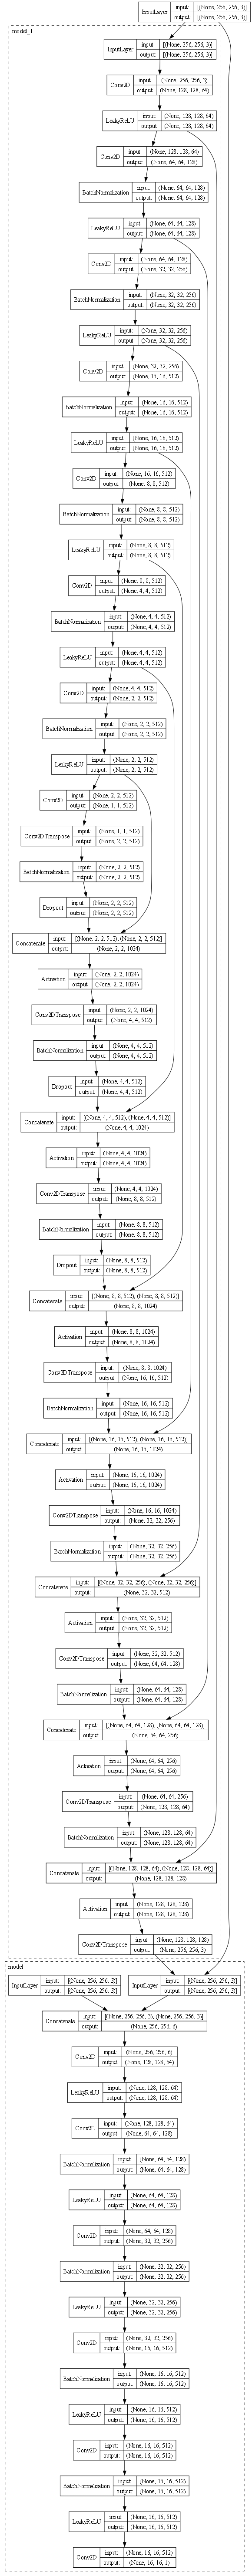

In [6]:
def buidGAN(Gmodel, Dmodel, input_shape):
    Dmodel.trainable = False
    input_img = Input(shape=input_shape)
    Gout = Gmodel(input_img)
    Dout = Dmodel([input_img, Gout])
    return Model(input_img, [Dout, Gout])

GAN = buidGAN(G, D, sat_images.shape[1:])
GAN.compile(loss=['binary_crossentropy', 'mae'], optimizer=Adam(0.0002, 0.5), loss_weights=[1,100])
GAN.summary(expand_nested=True)
plot_model(GAN, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

In [7]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples, verbose=0)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and plot them
def plot_sample_images(g_model, d_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    plt.show()

In [26]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1, plot_interval=10):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in tqdm(range(n_steps)):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        if i % (bat_per_epo*plot_interval-1) == 0:
            plot_sample_images(g_model, d_model, dataset)
            # save the model weights
            d_model.save_weights('pix2pix_D_weights.h5')
            g_model.save_weights('pix2pix_G_weights.h5')

  0%|          | 0/1096 [00:00<?, ?it/s]

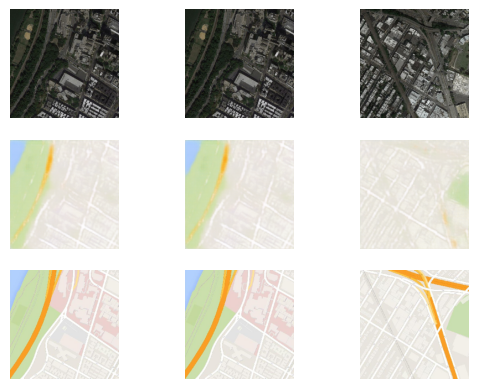

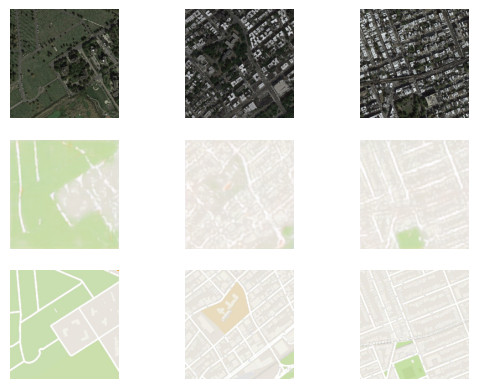

In [14]:
train(D, G, GAN, training_dataset, n_epochs=1, n_batch=1, plot_interval=1) 